# GPT4 Few-Shot Modeling for Software Citation Intent Prediction

In this notebok, we showcase an example of using a GPT4 model in a few-shot setting for predicting software citation intent.
Note that running this notebook requires access to an OpenAI API key, which can be retrieved from the OpenAI API website: https://openai.com/product#made-for-developers

In [1]:
import pandas as pd
import os
from openai import OpenAI
# your OpenAI key goes here
OPENAI_API_KEY = ""
client = OpenAI(api_key = OPENAI_API_KEY)
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
import warnings
import time
import plotly.express as px
from collections import Counter
warnings.simplefilter("ignore")

## Data Reading
The data used for training and testing has the following fields:
- **id**: paper_id (e.g. PMC id)
- **sentence**: sentence containing the software mention
- **used**: True if the intent of the software mentioned in the sentence is usage
- **created**: True if the intent of the software mentioned in the sentence is creation
- **mention**: True if the intent of the software mentioned in the sentence is mentioned
- **context**: context around the sentence, if available; this would be the leading and trailing sentence in the paragraph around the sentence
- **label**: categorical label; not that a sentence can only have one label
- **text**: same as sentence

In [2]:
data_df = pd.read_csv('../data/software_citation_intent_merged.csv')
LABEL2TEXT = {0 : 'creation', 1 : 'usage', 2 : 'mention', 3: 'none'}

In [3]:
data_df.head()

,Unnamed: 0,id,sentence,used,created,mention,context,label,text
0,0,PMC5189946,All of this analysis was implemented using Mat...,False,True,False,NaN,0,All of this analysis was implemented using Mat...
1,1,PMC4511233,"Code for calculating partition similarity, obt...",False,True,False,Since the probability of getting a given MI is...,0,"Code for calculating partition similarity, obt..."
2,2,PMC4186879,All behavioral statistical analyses were perfo...,False,False,True,All behavioral statistical analyses were perfo...,2,All behavioral statistical analyses were perfo...
3,3,PMC5026371,"M-Track was written using Python 2.7, OpenCV 3...",True,False,False,NaN,1,"M-Track was written using Python 2.7, OpenCV 3..."
4,4,PMC1283974,"Mindboggle is a freely downloadable, open sour...",False,True,False,"Mindboggle is a freely downloadable, open sour...",0,"Mindboggle is a freely downloadable, open sour..."


The data has been split into train and test, where test is used for validation. Note that in a zero-shot setting, we don't use the training split at all, and only test performance on the test split.

In [4]:
def update_context(df):
    df['context'] = df.apply(lambda x: x['context'] if x['context'] == x['context'] else x['sentence'], axis = 1)
update_context(data_df)

In [5]:
X_train_df = pd.read_csv('../data/gpt3.5_formatted_data/gpt3.5_train.csv')
X_test_df = pd.read_csv('../data/gpt3.5_formatted_data/gpt3.5_test.csv')
X_test_df['label_descriptive'] = X_test_df['label'].apply(lambda x: LABEL2TEXT[x])

update_context(X_train_df)
update_context(X_test_df)

In [6]:
Counter(X_test_df['label_descriptive'].to_list())

Counter({'usage': 449, 'none': 200, 'mention': 95, 'creation': 94})

## Few-shot GPT model

In [7]:
def predict_gpt(sentences, y_test, initial_message, model, print_every = 10, verbose = False):
    predicted_labels = []
    true_labels = []
    completed_sentences = []
    indices = range(len(sentences))
    for i, sentence, label in zip(indices, sentences, y_test):
        message = initial_message + [{"role": "user", "content": sentence.strip()}]
        try:
            completion = client.chat.completions.create(model=model, messages=message)
            predicted_class = completion.choices[0].message.content.lower().strip()
            if i % print_every == 0:
                if not verbose:
                    print('Predicting on sentence', str(i))
                else:
                    print(i, 'Sentence: ', sentence, '\nPredicted class:', predicted_class, 'Real class:' + label + '\n\n')
            predicted_labels.append(predicted_class)
            true_labels.append(label)
            completed_sentences.append(sentence)
        except:
            print('got an error')
            continue
    return predicted_labels, true_labels, completed_sentences

## Evaluation

In [8]:
def evaluate(true_labels, predicted_labels):
    p, r, f1, support = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
    accuracy = round(accuracy_score(true_labels, predicted_labels), 3)
    print('Precision: ', round(p, 3), 'Recall: ', round(r, 3), 'F1:', round(f1, 3), 'Accuracy:', accuracy)
    print(classification_report(true_labels, predicted_labels))

Notice that we are using n = 5 examples for the few-shot setting. This means that the model is seeing a number of 5 examples per class before making predictions. This parameter can be changed and experimented with

In [9]:
#number of few_shot examples 
num_examples_few_shot = 5

# this can be one of : 'sentence' or 'context'
pred_field = 'sentence' 

# sample num_examples_few_shot example sentences per label
examples_used = X_train_df[X_train_df['label_descriptive'] == 'usage'].sample(num_examples_few_shot)[pred_field].to_list()
examples_created = X_train_df[X_train_df['label_descriptive'] == 'creation'].sample(num_examples_few_shot)[pred_field].to_list()
examples_mentioned = X_train_df[X_train_df['label_descriptive'] == 'mention'].sample(num_examples_few_shot)[pred_field].to_list()
examples_none = X_train_df[X_train_df['label_descriptive'] == 'none'].sample(num_examples_few_shot)[pred_field].to_list()

# PROMPT 1
initial_message = [{"role": "system", 
                "content": "You are a scientist trying to figure out the citation intent behind software mentioned in sentences coming from research articles. Your four categories are: creation, usage, mention, or none. The definitions of the classes are: \
                - creation: software was created by the authors of the paper \
                - usage: software was used in the paper \
                - mention: software was mentioned in the paper, but not used, nor created \
                - none: none of the previous 3 categories apply \
                You need to output one category only."}]
for example in examples_used:
    initial_message += [{"role": "user", "content" : example}]
    initial_message += [{"role": "assistant", "content" : 'usage'}]
for example in examples_created:
    initial_message += [{"role": "user", "content" : example}]
    initial_message += [{"role": "assistant", "content" : 'creation'}]
for example in examples_mentioned:
    initial_message += [{"role": "user", "content" : example}]
    initial_message += [{"role": "assistant", "content" : 'mention'}]
for example in examples_none:
    initial_message += [{"role": "user", "content" : example}]
    initial_message += [{"role": "assistant", "content" : 'none'}]

### Test split

In [10]:
test_sentences = X_test_df[pred_field].to_list()
y_test = X_test_df['label_descriptive'].to_list()
y_test_pred_completed, y_test_true_completed, test_completed_sentences = predict_gpt(test_sentences, y_test, initial_message, 'gpt-4', print_every = 1)

Predicting on sentence 0
Predicting on sentence 1
Predicting on sentence 2
Predicting on sentence 3
Predicting on sentence 4
Predicting on sentence 5
Predicting on sentence 6
Predicting on sentence 7
Predicting on sentence 8
Predicting on sentence 9
Predicting on sentence 10
Predicting on sentence 11
Predicting on sentence 12
Predicting on sentence 13
Predicting on sentence 14
Predicting on sentence 15
Predicting on sentence 16
Predicting on sentence 17
Predicting on sentence 18
Predicting on sentence 19
Predicting on sentence 20
Predicting on sentence 21
Predicting on sentence 22
Predicting on sentence 23
Predicting on sentence 24
Predicting on sentence 25
Predicting on sentence 26
Predicting on sentence 27
Predicting on sentence 28
Predicting on sentence 29
Predicting on sentence 30
Predicting on sentence 31
Predicting on sentence 32
Predicting on sentence 33
Predicting on sentence 34
Predicting on sentence 35
Predicting on sentence 36
Predicting on sentence 37
Predicting on sentence

In [11]:
print('Finished', len(y_test_true_completed), 'sentences out of', len(X_test_df))
evaluate(y_test_true_completed, y_test_pred_completed)

Finished 838 sentences out of 838
Precision:  0.746 Recall:  0.736 F1: 0.738 Accuracy: 0.839
              precision    recall  f1-score   support

    creation       0.74      0.62      0.67        94
     mention       0.46      0.44      0.45        95
        none       0.86      0.97      0.91       200
       usage       0.93      0.91      0.92       449

    accuracy                           0.84       838
   macro avg       0.75      0.74      0.74       838
weighted avg       0.84      0.84      0.84       838



In [12]:
Counter(y_test_true_completed)

Counter({'usage': 449, 'none': 200, 'mention': 95, 'creation': 94})

### CZI validation dataset

In [20]:
czi_val_df = pd.read_csv('../data/czi_val_merged.csv').drop_duplicates()
czi_val_df['label'] = czi_val_df['label'].apply(lambda x: 'mention' if x == 'none' else x)
test_sentences_czi = czi_val_df['text'].to_list()
y_czi_val = czi_val_df['label'].to_list()
y_pred_completed_czi, y_true_completed_czi, test_completed_sentences_czi = predict_gpt(test_sentences_czi, y_czi_val, initial_message, "gpt-3.5-turbo", print_every = 1)

Predicting on sentence 0
Predicting on sentence 1
Predicting on sentence 2
Predicting on sentence 3
Predicting on sentence 4
Predicting on sentence 5
Predicting on sentence 6
Predicting on sentence 7
Predicting on sentence 8
Predicting on sentence 9
Predicting on sentence 10
Predicting on sentence 11
Predicting on sentence 12
Predicting on sentence 13
Predicting on sentence 14
Predicting on sentence 15
Predicting on sentence 16
Predicting on sentence 17
Predicting on sentence 18
Predicting on sentence 19
Predicting on sentence 20
Predicting on sentence 21
Predicting on sentence 22
Predicting on sentence 23
Predicting on sentence 24
Predicting on sentence 25
Predicting on sentence 26
Predicting on sentence 27
Predicting on sentence 28
Predicting on sentence 29
Predicting on sentence 30
Predicting on sentence 31
Predicting on sentence 32
Predicting on sentence 33
Predicting on sentence 34
Predicting on sentence 35
Predicting on sentence 36
Predicting on sentence 37
Predicting on sentence

In [21]:
print('Completed', len(test_completed_sentences_czi), '/', len(test_sentences_czi))
evaluate(y_true_completed_czi, y_pred_completed_czi)

Completed 210 / 210
Precision:  0.473 Recall:  0.385 F1: 0.421 Accuracy: 0.614
              precision    recall  f1-score   support

    creation       0.70      0.70      0.70        10
     mention       0.21      0.17      0.19        23
        none       0.00      0.00      0.00         0
       usage       0.98      0.67      0.79       177

    accuracy                           0.61       210
   macro avg       0.47      0.39      0.42       210
weighted avg       0.89      0.61      0.72       210



### Error Analysis

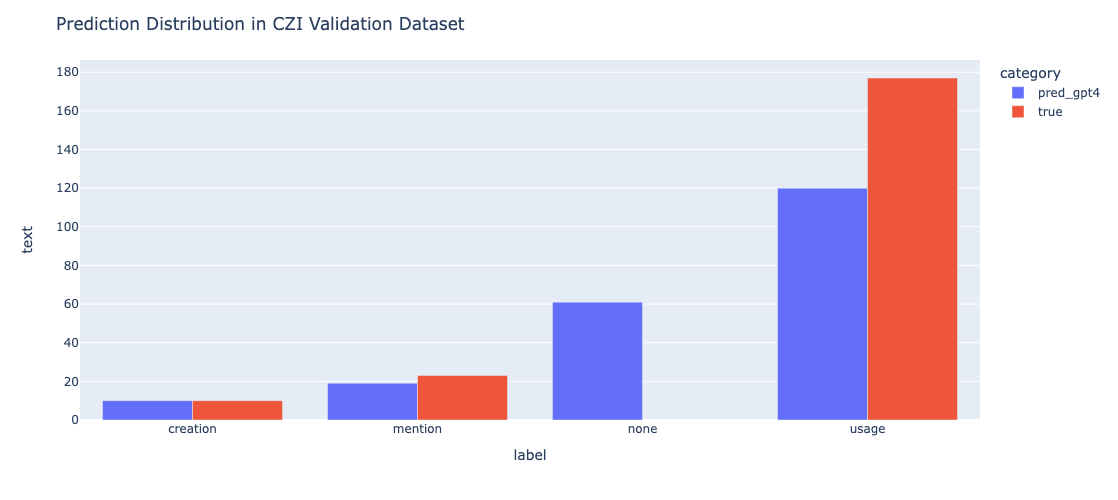

In [26]:
def get_pred_label(x, completed_sentences, y_pred_completed):
    for sent, label in zip(completed_sentences, y_pred_completed):
        if sent == x:
            return label
    return 'no_prediction'
    
czi_val_df['category'] = 'true'
czi_val_df['pred_label'] = czi_val_df['text'].apply(lambda x: get_pred_label(x, test_completed_sentences_czi, y_pred_completed_czi))
czi_val_df_pred = czi_val_df.copy()
czi_val_df_pred['category'] = 'pred_gpt4'
czi_val_df_pred['label'] = czi_val_df_pred['pred_label']


czi_val_df_all = pd.concat([czi_val_df_pred, czi_val_df])

labels_grouped = czi_val_df_all.groupby(['label', 'category']).count().reset_index()
fig = px.bar(labels_grouped, x = 'label', y = 'text', color = 'category', barmode = 'group')
fig.update_layout(width=800,height=500, title = 'Prediction Distribution in CZI Validation Dataset')

#### False positives

In [23]:
pd.set_option('display.max_colwidth', 1000)
czi_val_df[(czi_val_df['pred_label'] == 'mention') & (czi_val_df['label'] != 'mention')]

,doi_link,source,text,software,intent,label,category,pred_label
23,https://doi.org/10.1371/journal.pone.0163668,Statistical analysis,"We computed pairwise LD statistics (D’ and r2) and haplotype frequencies using Haploview 4.0 (Broad Institute of MIT and Harvard, Cambridge, MA)",Haploview,used,usage,true,mention
26,https://doi.org/10.3390/pathogens10030277,NaN,Evolutionary analyses were conducted in MEGA X [19].,MEGA X,used,usage,true,mention
32,https://doi.org/10.1038/s41598-017-02942-3,Stimuli and Apparatus,"Stimuli presentation and behavioral data collection were performed using E-Prime v2.0 (Psychology Software Tools, Pittsburgh, PA)",E-Prime,used,usage,true,mention
35,https://doi.org/10.1111/jpi.12673,Implementation details,The website is written in the Python programming language using the ‘Flask’ framework,Flask,used,usage,true,mention
62,https://doi.org/10.1136/bmjopen-2016-013606,Statistical analyses,All data will be analysed using SPSS (V.21) and STATA (Release V.12),STATA,used,usage,true,mention
82,https://doi.org/10.3390/ijerph13020152,2. Experimental Section,MiSeq forward and reverse reads were paired using the PANDAseq v.2.9 [28] with default parameters,PANDAseq,used,usage,true,mention
99,https://doi.org/10.1038/s41598-021-83798-6,fig_caption,"Maps created in ArcMap v.10.5.1 (ESRI, https://www.esri.com/).",ArcMap,used,usage,true,mention
103,https://doi.org/10.1186/s12913-018-2859-6,Data analysis,Using SPSS (v,SPSS,used,usage,true,mention
120,https://doi.org/10.2196/13362,Statistical Analysis,"Statistical calculations were done using built-in functions in Matlab R2018a (The MathWorks, Inc).",Matlab,used,usage,true,mention
152,https://doi.org/10.1016/j.dib.2019.104507,"Experimental design, materials and methods","The GeoJSON files, which can be used to test the performance of JSTS, are available in Datasets 1–10.",GeoJSON,used,usage,true,mention


#### False negatives

In [24]:
czi_val_df[(czi_val_df['label'] == 'usage') & (czi_val_df['pred_label'] != 'usage')]

,doi_link,source,text,software,intent,label,category,pred_label
1,https://doi.org/10.1155/2014/395212,5. Simulation Results and Analysis,"In Figure 11, p miss of SVM-SMP is nearly equal to 0, which is much better than SVM-LA",SVM,used,usage,true,none
2,https://doi.org/10.3389/fphys.2020.587057,Network Architecture and Training Parameters,A pattern recognition network was created using MATLAB r2017b to study the performance of the extracted gait parameters,MATLAB,used,usage,true,creation
3,https://doi.org/10.1186/s13046-018-0997-7,paper_abstract,"Finally, we investigated the potential molecular mechanism of ARNTL by gene set enrichment analysis (GSEA), dual Luciferase reporter assay and chromatin immunoprecipitation assay",analysis (GSEA),used,usage,true,none
4,https://doi.org/10.7717/peerj.9470,Conclusions,"The GitHub repository for this study has been created, including the Python scripts and the datasets used in this study (see https://github.com/smiile8888/rna-splice-sites-recognition)",Python,used,usage,true,creation
12,https://doi.org/10.7554/eLife.05005,Collection and processing of previous predictions,"For algorithms providing multiple transcript-level predictions (i.e., miRanda-MicroCosm, PACCMIT-CDS, and TargetSpy), the transcript with the best score was selected as the representative transcript isoform",TargetSpy,used,usage,true,none
15,https://doi.org/10.1186/2041-1480-2-9,NaN,An OWL DL query of Brucella virulent factors also being protective antigens using the OWL editor Protégé 4,Protégé,used,usage,true,none
17,https://doi.org/10.3390/molecules18022166,3.6. Optimal Proportioning Design of Synergistic Effect on GBP with Isophytol against Salmonella Enterica,"This design was based on the Mixture Design (D-optimal, two mixture components, two factors, the limits: 5%–95%) option in the Design Expert 7.1.3 Software that generated the experimental scheme (13 standard/run) randomly",Design Expert,used,usage,true,none
22,https://doi.org/10.3389/fpls.2014.00567,RAxML,"To compare the average distance-based POFAD output with that from a character-based tree-building analysis we first merged allelic/haplotype sequences for each individual cultivar by calculating their consensus (including IUPAC bases) using Bio Edit version 7 (http://www.mbio.ncsu.edu/BioEdit/bioedit.html), and then aligning them with other cultivars and concatenate the alignments of all contigs using Mesquite version 2.75 (Maddison and Maddison, 2011)",Mesquite,used,usage,true,none
23,https://doi.org/10.1371/journal.pone.0163668,Statistical analysis,"We computed pairwise LD statistics (D’ and r2) and haplotype frequencies using Haploview 4.0 (Broad Institute of MIT and Harvard, Cambridge, MA)",Haploview,used,usage,true,mention
26,https://doi.org/10.3390/pathogens10030277,NaN,Evolutionary analyses were conducted in MEGA X [19].,MEGA X,used,usage,true,mention


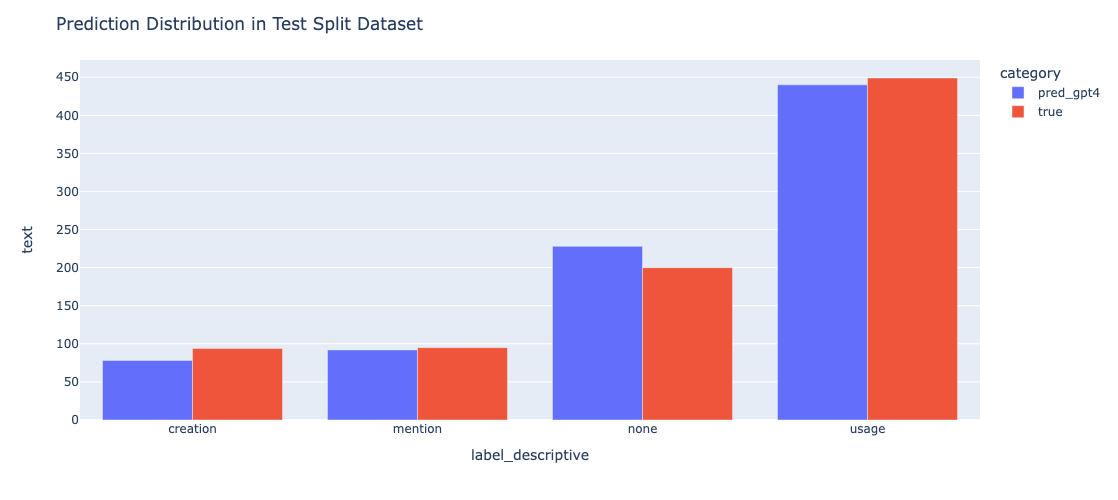

In [25]:
X_test_df['category'] = 'true'
X_test_df['pred_label'] = X_test_df['text'].apply(lambda x: get_pred_label(x, test_completed_sentences, y_test_pred_completed))
X_test_df_pred = X_test_df.copy()
X_test_df_pred['category'] = 'pred_gpt4'
X_test_df_pred['label_descriptive'] = X_test_df_pred['pred_label']

X_test_df_all = pd.concat([X_test_df_pred, X_test_df])

labels_grouped = X_test_df_all.groupby(['label_descriptive', 'category']).count().reset_index()
fig = px.bar(labels_grouped, x = 'label_descriptive', y = 'text', color = 'category', barmode = 'group')
fig.update_layout(width=800,height=500, title = 'Prediction Distribution in Test Split Dataset')